In [6]:
from significance_of_mean_cuda import significance_of_mean_cuda
from utils import significance_of_mean, getdf, my_scatter_plot
import numpy as np
import time
import multiprocessing
import concurrent.futures as cf
import matplotlib.pyplot as plt

In [7]:
import pandas as pd
import seaborn as sns

In [8]:
import matplotlib as mpl

mpl.rcParams['text.usetex'] = False  # not really needed

### Get synthetic data

In [9]:
num_examples = 1

In [10]:
N = [50,100, 150, 200, 250]
s =  [10, 50, 100, 200]

#### The calculations are parallelized over the samples on five cores in total. 

In [11]:
def p_value_calc(args):
    a,b, bins = args
    p=significance_of_mean(a,b, bins)[0]
    return p

def calibration_series_generator(A,B, S):
    num_tests = A.shape[0]
    for i in range(num_tests):
        a_sample = A[i].tolist()
        b_sample = B[i].tolist()
        yield ([a_sample,b_sample, S])

def calibration_test(A,B,bins):
    with cf.ProcessPoolExecutor(max_workers=multiprocessing.cpu_count()-3) as pool:
        p_list = list(pool.map(p_value_calc, calibration_series_generator(A,B, bins)))
    return p_list
    

In [12]:
def preparePandas(timeData, sampleSizes, test="Parallelization"):
    preparePd = list()
    for time, sample in zip(timeData, sampleSizes):
        preparePd.append([str(test),time, sample])
        
            
    return preparePd

In [13]:
path = "figures/parallelVsSingleThread"

In [14]:
def timePlotSNS(TIMEParallel, TIMEsingleThred, sampleShape,binVar=False, log=False, path=None):

    
    preparePdParallel = preparePandas(TIMEParallel, sampleShape)
    preparePdSingle = preparePandas(TIMEsingleThred, sampleShape, 'Single thread')
    
    data = preparePdParallel + preparePdSingle
    
    pdData = pd.DataFrame(data, columns=['Method', 'time(s)','bins'])
    
    if log:        
        MAX = max(max(TIMEParallel), max(TIMEsingleThred))
        MIN = min(min(TIMEParallel), min(TIMEsingleThred))

        RANGE = np.arange(np.floor(MIN), np.ceil(MAX))
        snsPlot = sns.lineplot(x="bins", y="time(s)",
             hue="Method",
             data=pdData)#.set(yticks = RANGE, yticklabels=10**RANGE)
        plt.yticks(RANGE, 10.0**RANGE)
        
        
    else:
        snsPlot = sns.lineplot(x="bins", y="time(s)",
             hue="Method",
             data=pdData,)
    
    if binVar:
        plt.xlabel(r"$n$")
        
    else:
        plt.xlabel(r"$n_{w}$")
    
    
    
    #plt.legend(loc='upper left')
    plt.setp(snsPlot.get_legend().get_texts(), fontsize='12')
    plt.tight_layout()
    
    if path:   
        fig = snsPlot.get_figure()
        fig.savefig(path)



In [15]:
def getPATH(path, name):
    return path + '/'+ name 

In [ ]:
cpu1 = list()
gpu1 = list()
n = N[1]
for bins in s:
    np.random.seed(42)
    A = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])
    B = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])

    start = time.time()
    SGM = significance_of_mean_cuda(bins,dtype_v=np.uint16,dtype_A=np.float64)
    SGM.run(A,B)
    p = SGM.get_p_values()
    end = time.time()
    t_gpu = end - start
    gpu1.append(t_gpu)
    print("GPU: ", t_gpu)
    
    
    start = time.time()
    P = calibration_test(A,B,bins)
    end = time.time()
    t_cpu = end - start
    cpu1.append(t_cpu)
    print("CPU1: ",t_cpu)
    
    print(np.allclose(p,P))
    

In [ ]:
timePlotSNS(np.array(gpu1), np.array(cpu1), np.array(s), log=False, path=getPATH(path, "VarS"))

In [ ]:
timePlotSNS(np.log10(np.array(gpu1)), np.log10(np.array(cpu1)), np.array(s), log=True, path=getPATH(path, "VarSLog"))

In [ ]:
plt.plot(s, cpu1, 'r-', label='Not parallelized')
plt.plot(s, gpu1, 'g-', label='Parallelized')
plt.legend(loc='upper left')
plt.xlabel(r"$n$")
plt.ylabel("Time(s)")
plt.tight_layout()
plt.savefig("figures/normal_N")
plt.show()

In [ ]:
cpu2 = list()
gpu2 = list()
bins = s[2]
for n in N:
    np.random.seed(42)
    A = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])
    B = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])

    start = time.time()
    SGM = significance_of_mean_cuda(bins,dtype_v=np.uint16,dtype_A=np.float64)
    SGM.run(A,B)
    p = SGM.get_p_values()
    end = time.time()
    t_gpu = end - start
    gpu2.append(t_gpu)
    print("GPU: ", t_gpu)
    
    
    start = time.time()
    P = calibration_test(A,B,bins)
    end = time.time()
    t_cpu = end - start
    cpu2.append(t_cpu)
    print("CPU: ",t_cpu)
    
    print(np.allclose(p,P))

In [ ]:
timePlotSNS(np.array(gpu2), np.array(cpu2), np.array(N), log=False, binVar=True,path=getPATH(path, "VarN"))

In [ ]:
timePlotSNS(np.log10(np.array(gpu2)), np.log10(np.array(cpu2)), np.array(N), log=True, binVar=True, path=getPATH(path, "VarNLog"))

In [ ]:
plt.plot(N, cpu2, 'r-', label='Not parallelized')
plt.plot(N, gpu2, 'g-', label='Parallelized')
plt.legend(loc='upper left')
plt.xlabel(r"$n$")
plt.ylabel("Time(s)")
plt.tight_layout()
plt.savefig("figures/normal_N")
plt.show()

In [ ]:
num_examples = 200
n = N[1]
bins = s[2]

np.random.seed(42)
A = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])
B = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])

SGM = significance_of_mean_cuda(bins,dtype_v=np.uint16,dtype_A=np.float64)
SGM.run(A,B)
p = SGM.get_p_values()

pDf = getdf(p, num_examples)
my_scatter_plot(pDf,"figures/normal_calibration")

In [ ]:
bins = np.linspace(np.min(A, axis=1), np.max(A, axis=1), 50)

In [ ]:
bins

In [16]:
pre = [0.5,1.5,2,2.1,2.5,3,3.5,4,4.1,4.5]
#pre = [13]

In [17]:
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]


In [18]:
gpu1 = list()
for p in pre:
    n_samples = int(p * 1_000)
    A = np.asarray([np.random.normal(0, 1, 80) for _ in range(n_samples)])
    B = np.asarray([np.random.normal(0, 1, 80) for _ in range(n_samples)])
    
    start = time.time()
    for i, (a, b) in enumerate(zip(batch(A, 2_000), batch(B, 2_000))):
        print(i)
        SGM = significance_of_mean_cuda(50,dtype_v=np.uint16,dtype_A=np.float64)
        SGM.run(a,b)
    
    end = time.time()
    t_gpu = end - start
    gpu1.append(t_gpu)
    print("GPU: ", t_gpu)

0
GPU:  11.357204675674438
0
GPU:  34.36758303642273
0
GPU:  45.39064264297485
0
1
GPU:  47.76288414001465
0
1
GPU:  56.86008882522583
0
1
GPU:  68.29274272918701
0
1
GPU:  79.94770193099976
0
1
GPU:  90.41415190696716
0
1
2
GPU:  92.88887643814087
0
1
2
GPU:  101.99948239326477


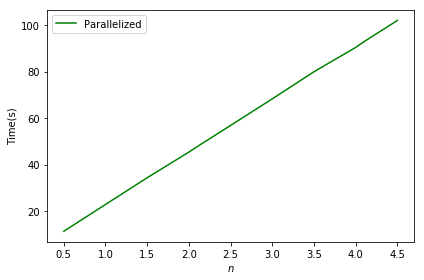

In [19]:

plt.plot(pre, gpu1, 'g-', label='Parallelized')
plt.legend(loc='upper left')
plt.xlabel(r"$n$")
plt.ylabel("Time(s)")
plt.tight_layout()
plt.savefig("figures/normal_N")
plt.show()

In [ ]:
SGM = significance_of_mean_cuda(50,dtype_v=np.uint16,dtype_A=np.float64)
SGM.run(A,B)

In [ ]:
cpu1 = list()
gpu1 = list()
n = N[1]
for bins in s:
    np.random.seed(42)
    A = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])
    B = np.asarray([np.random.normal(0, 1, n) for _ in range(num_examples)])

    start = time.time()
    SGM = significance_of_mean_cuda(bins,dtype_v=np.uint16,dtype_A=np.float64)
    SGM.run(A,B)
    p = SGM.get_p_values()
    end = time.time()
    t_gpu = end - start
    gpu1.append(t_gpu)
    print("GPU: ", t_gpu)
    
    
    start = time.time()
    P = calibration_test(A,B,bins)
    end = time.time()
    t_cpu = end - start
    cpu1.append(t_cpu)
    print("CPU1: ",t_cpu)
    
    print(np.allclose(p,P))
